In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.datasets import *
from fastai.vision import *
from fastai import *

import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import json



In [3]:
ROOT_PATH=Path('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/')
DATA_PATH=Path(ROOT_PATH/'data')
VOC_DEVKIT_PATH = Path(DATA_PATH/'VOCdevkit')
MODEL_PATH=Path(ROOT_PATH/'model')
TRAIN_PATH=Path(ROOT_PATH/'train')               
VOC_DEVKIT_PATH.ls()





[PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/pascal_val2007.json'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/.ipynb_checkpoints'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/pascal_train2007.json')]

In [4]:
train_json_path = Path(VOC_DEVKIT_PATH/'pascal_train2007.json')
with open(train_json_path, 'r') as f:
    train_json = json.loads(f.read())

IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']



In [5]:
train_json[IMAGES][:5], train_json[ANNOTATIONS][:3],train_json[CATEGORIES][:5]

([{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
  {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
  {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
  {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
  {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}],
 [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
   'area': 34104,
   'iscrowd': 0,
   'image_id': 12,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0},
  {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
   'area': 13110,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0},
  {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
   'area': 81326,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0}],
 [{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},


### Create dict from id to category (dict[id] -> category)

In [6]:
categories = dict([(c['id'], c['name']) for c in train_json[CATEGORIES]])

### Create map of id to image file (dict[id] -> filename)

In [7]:
images = dict([(i['id'], i['file_name']) for i in train_json['images']])

### List of image ids

In [8]:
image_ids = [i['id'] for i in train_json['images']]

In [9]:
JPEGS_PATH = Path(VOC_DEVKIT_PATH/'VOC2007'/'JPEGImages')
IMAGES_PATH = JPEGS_PATH
JPEGS_PATH.ls()[:5]

[PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/001618.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/005169.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/002201.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/006238.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/005960.jpg')]

In [10]:
train_json[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

### Create a dict with image_id to bounding box and category dict[image_id] -> (bbox, category)

1. The goal here is to create a dictionary that maps an `image_id` to the `bbox` and `category`
2. This requires a few additional helper methods described below 

<br>

### Helper methods
<br>




#### Changing BBOX representation format
1. The information in the `annotations` dictionary has an attribute called `bbox` which is represented in a notation usually used in ML, which is width by height whereas most libraries and math representation is width by height 

<br>

#### TLDR;
 - Math world - rows by columns (height by width)
 - Computer Vision  - columns by rows (width by height)



In [11]:
def create_train_annotations(train_json:dict):
    """
    1. creates an annotations dictionary 
    2. converts the format in which height and width is stored in the 
    annotations dictionary of the train_json dict.
    3. Also converts the height and width information to top left x, y cordinate and bottom right x, y coordinate
    Hence the subtraction information
    """
    annotations = collections.defaultdict(lambda:[])
    for o in train_json[ANNOTATIONS]:
        bbox = o['bbox']
        bb = np.array([bbox[1], bbox[0], bbox[3]+bbox[1], bbox[2]+bbox[0]])
        annotations[o['image_id']].append((bb, o['category_id']))
    return annotations

def get_category(category_id): 
    cat = categories.get(category_id, None)
    if not cat: 
        cat = val_categories.get(category_id, None)
    return cat

def get_image_filename(image_id): 
    filename = images.get(image_id, None)
    if not filename:
        filename = val_images.get(image_id, None)
    return filename
        
def _get_annotations(image_id): 
    annot =  annotations.get(image_id, None)
    if not annot:
        annot = val_annotations.get(image_id, None)
    return annot


def convert_bb_to_height_and_width(bbox):
    """
    Does the opposite. 
    1. Converts bbox x, y coordinates for top left and bottom right to height and width information
    """
    bb = bbox
    return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

def _open_image(filename):
    """
    1. opens an image with just the filename using the standard `open_image` method
    """
    return open_image(JPEGS_PATH/filename)

def _display_with_bbox(img_filename, bbox:list=None):
    """
    1. Creates bounding boxes using FastAIs ImageBBox api
    """
    if isinstance(img_filename, str):
        img = _open_image(img_filename)
    else:
        img = img_filename
        
    if not isinstance(bbox, ImageBBox):        
        bb, category = bbox    
        category_name = category if isinstance(category, list) else get_category(category)
        img_bbox = ImageBBox.create(*img.size, bb, labels=[0], classes=list(category_name))        
    else:
        img_bbox = bbox
    img.show(y=img_bbox, figsize=(5, 5))
    
def _get_largest_img_bbox(img_annotation):
    if not img_annotation: raise Exception
    sorted_bbox = sorted(img_annotation, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return sorted_bbox[0]


def display_batch(ds_type:DatasetType=DatasetType.Train, num=15):
    x, y = data.one_batch(ds_type=ds_type)
    
    if ds_type == DatasetType.Train:
        xs = [ data.train_ds.x.reconstruct(grab_idx(x, i)) for i in range(num)]
        ys = [ data.train_ds.y.reconstruct(grab_idx(y, idx), x=x) for idx, x in enumerate(xs)]
    else:
        xs = [ data.valid_ds.x.reconstruct(grab_idx(x, i)) for i in range(num)]
        ys = [ data.valid_ds.y.reconstruct(grab_idx(y, idx), x=x) for idx, x in enumerate(xs)]
    axs = subplots(3, 3, imgsize=(5, 5), figsize=(20, 20))
    for im, bb, ax in zip(xs, ys, axs.flatten()):     
        im.show(ax=ax, y=bb, hide_axis=False)
        ax.grid(b=True, color='gray', visible=True, zorder=0.8)
        ax.set_axisbelow(True)    
    
    

In [12]:
annotations = create_train_annotations(train_json)
get_category(7), get_image_filename(12)

('car', '000012.jpg')

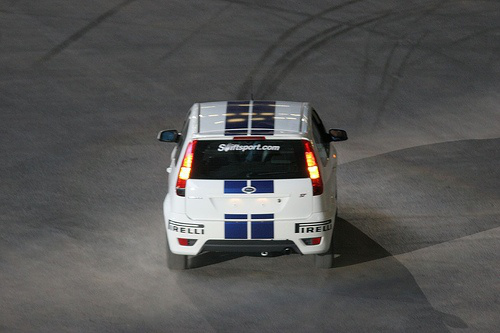

In [13]:
first_img = list(images.values())[0]
_open_image(first_img)

### Creating images with bounding boxes using ImageBBox

```python
img = open_image('imgs/car_bbox.jpg')
bbox = ImageBBox.create(*img.size, [[96, 155, 270, 351]], labels=[0], classes=['car'])
img.show(y=bbox)
```

### Use fastai helper to fetch json data `get_annotations`

In [14]:
imgs, lbl_bbox = get_annotations(VOC_DEVKIT_PATH/'pascal_train2007.json')
imgs_valid, lbl_bbox_valid = get_annotations(VOC_DEVKIT_PATH/'pascal_val2007.json')

imgs2bbox = dict(zip(imgs, lbl_bbox))
imgs2bbox_valid = dict(zip(imgs_valid, lbl_bbox_valid))

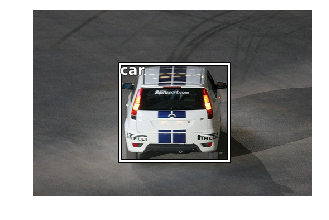

In [15]:
imgs[0], lbl_bbox[0]

_display_with_bbox(imgs[0], lbl_bbox[0])

### Create a label function to pull the bbox and classes from the `img2bbox and img2bbox_valid` dictionaries

In [16]:
def get_y_func(o):
    bbox_classes = imgs2bbox.get(o.name, None)
    if not bbox_classes: bbox_classes = imgs2bbox_valid.get(o.name, None)
    bbox, classes = bbox_classes
    return [bbox, classes]

In [17]:
print(get_y_func(Path(JPEGS_PATH/f'{imgs[0]}')))
print(get_y_func(Path(JPEGS_PATH/f'{imgs_valid[0]}')))

[[[96, 155, 270, 351]], ['car']]
[[[210, 262, 339, 324], [263, 164, 372, 253], [243, 4, 374, 67], [193, 240, 299, 295], [185, 276, 220, 312]], ['chair', 'chair', 'chair', 'chair', 'chair']]


In [18]:
from fastai.vision.data import bb_pad_collate

In [19]:
data = ObjectItemList.from_folder(JPEGS_PATH)
data = data.split_by_files(imgs_valid)
data = data.label_from_func(get_y_func)
data = data.transform(get_transforms(max_zoom=1, max_warp=0.05, 
                                     max_rotate=0.05, max_lighting=0.2),
                     tfm_y=True, size=224, resize_method=ResizeMethod.SQUISH)
data = data.databunch(bs=16, collate_fn=bb_pad_collate, no_check=True)

In [20]:
data

ImageDataBunch;

Train: LabelList (2501 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (2510 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None

In [ ]:
display_batch(DatasetType.Valid)


### MultiClass Object Detection 

1. One approach is to allow the models last layer to return (4 + data.c) where 4 is the bounding box coordinates and c is the class of the predicted grid
2. We could also ensure it returns $16 * (4+data.c)$ to return 16 bounding boxes with 4 coordinate bounding boxes for each along with class 
3. `c = len(cats)`

### Not a linear final layer anymore

1. Instead of an `nn.Linear` final layer we have an `nn.Conv2D` final layer
2. The final layer of Resnet is $7x7x512$ and adding a `Conv2D` with `stride=2` would result in an output of shape `4x4x(4+data.c)`


### YOLO vs SSD (Single Shot Detector)

1. YOLO uses the `nn.Linear` final layer which returns a single vector
2. YOLO v3 and SSD uses a convolutional layer which returns $4x4x(4+data.c)$

### Stride 2 Conv2d is the same as Conv2D with MaxPooling

### How do we end up with an output of shape 16 x (4 + c)

1. Where `c` is the number of classes. 
2. The layer before the output layer is of shape `(256 x 7 x 7 )`

```
[SSDhead] input shape torch.Size([16, 512, 7, 7])
[SSDHead-1] relu-dropout output shape torch.Size([16, 512, 7, 7])
[SSDHead-2] sconv0 output shape torch.Size([16, 256, 7, 7])
[SSDHead-3] sconv0 output shape torch.Size([16, 256, 4, 4])
[SSDHead-4] out output shape (2,)
```

Our SSD which looks like 

```python
    def __init__(self, k, bias, num_of_classes):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1) 
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, num_of_classes, bias)
        
    def forward(self, x):
        print(f'[SSDhead] input shape {x.shape}')
        x = self.drop(F.relu(x))
        print(f'[SSDHead-1] relu-dropout output shape {x.shape}')
        x = self.sconv0(x)
        print(f'[SSDHead-2] sconv0 output shape {x.shape}')
        x = self.sconv2(x)
        print(f'[SSDHead-3] sconv2 output shape {x.shape}')
        x = self.out(x)
        print(f'[SSDHead-4] out output shape {np.array(x).shape}')
        return x
    
```

1. Has a convolution which accepts the `512 x 7 x 7` from the last resnet layer. 
2. This is followed by a stride 1 (`self.sconv0 = StdConv(512, 256, stride=1)`) which doesn't change the shape of activations.
3. The next layer `svconv2` is a standard Conv2d with stride 2 which would reduce the shape to `4x4` which gives us the 16 additional activations.
4. So when flattened our output shape looks like 16 x ( 4 + c ) but since our `OutConv` layer separates the results into two lists 

```python
class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels=nin, out_channels=((num_classes) * k), kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):        
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]
```

We end up with two outputs of shape 
1. 16x(c) - 16 x 16 x 21 
2. 16x(4) - 16 x 16 x 4

With the first 16 denoting the batch size in this example


In [ ]:
conv2d.__module__

## Architecture


### Defining our new final layers 

1. A `StdConv` a basic convolutional layer with `Conv2d`, `BatchNorm2d` and `Dropout`

In [ ]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, kernel_size=3, stride=2, padding=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

### What Flatten is doing internally

1. Assuming we have a 4x4 input 

```python
t =    torch.tensor([[ 5.1227e-01,  7.6558e-02,  1.5598e+00,  9.6250e-01],
          [-8.7642e-01,  9.7873e-01,  2.1760e+00,  1.2043e+00],
          [-1.6135e+00,  4.4954e-01,  3.6084e-01,  1.3405e-01],
          [-4.0809e-01, -2.2286e-01, -8.5558e-01,  8.2284e-01]])

print(t.shape)
>> torch.Size([4, 4])

print(t.view(t.shape[0], t.shape[1], -1))
>> tensor([[[ 0.5123],
         [ 0.0766],
         [ 1.5598],
         [ 0.9625]],

        [[-0.8764],
         [ 0.9787],
         [ 2.1760],
         [ 1.2043]],

        [[-1.6135],
         [ 0.4495],
         [ 0.3608],
         [ 0.1340]],

        [[-0.4081],
         [-0.2229],
         [-0.8556],
         [ 0.8228]]])

t.view(t.shape[0], t.shape[1], -1).transpose(1, 2)
>> tensor([[[ 0.5123,  0.0766,  1.5598,  0.9625]],

        [[-0.8764,  0.9787,  2.1760,  1.2043]],

        [[-1.6135,  0.4495,  0.3608,  0.1340]],

        [[-0.4081, -0.2229, -0.8556,  0.8228]]])

t.view(t.shape[0], t.shape[1], -1).transpose(1, 2).shape
>>torch.Size([4,1,4])
```



In [73]:
def flatten_conv(x, k, debug=False): 
    if debug:
        print(f'[Flatten] Input shape {x.shape}')
        print(f'[Flatten] Input {x}')
        
    flattened = x.view(x.size(0), x.size(1)//k, -1).transpose(1, 2)
    
    if debug:
        print(f'[Flatten-2] Flattened shape {flattened.shape}')
        print(f'[Flatten] Input {flattened}')
    return flattened

### Visualize the outcome of StdConv

1. We have 3 input channels for a color image
2. 64 filters and a kernel size of $3x3$

In [ ]:
x, y = data.one_batch()
print(f'Input shape: {x.shape}')
s = StdConv(3, 64, kernel_size=3, stride=1)
x_ = s.forward(x)
print("Output shape {x_.shape}")

Input shape: torch.Size([16, 3, 224, 224])
Output shape {x_.shape}


### OutConv defines the output layer

In [ ]:
class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels=nin, out_channels=((num_classes) * k), kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):        
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]
        

In [79]:
class SSDHead(nn.Module):
    def __init__(self, k, bias, num_of_classes):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1) 
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, num_of_classes, bias)
        
    def forward(self, x):
        print(f'[SSDhead] input shape {x.shape}')
        x = self.drop(F.relu(x))
        print(f'[SSDHead-1] relu-dropout output shape {x.shape}')
        x = self.sconv0(x)
        print(f'[SSDHead-2] sconv0 output shape {x.shape}')
        x = self.sconv2(x)
        print(f'[SSDHead-3] sconv2 output shape {x.shape}')
        x = self.out(x)
        print(f'[SSDHead-4] out output shape {np.array(x).shape}')
        return x
    
    

In [ ]:
k = 1
bias = -3.
head_reg4 = SSDHead(k, bias, data.c)


### Anchors in summary

- Details on how each line of the anchors works can be found below

In [78]:
from torch.autograd import Variable as V

anc_grid = 4
k = 1


anc_offset = 1/(anc_grid*2) # 0.125
four_point_grid = np.linspace(anc_offset, 1-anc_offset, anc_grid)
anc_x = np.repeat(four_point_grid, anc_grid)
anc_y = np.tile(four_point_grid, anc_grid); anc_y

# anchor centers
anc_centers = np.stack([anc_x, anc_y], axis=1);
anc_ctrs = np.tile(anc_centers, (k, 1))

# anchor sizes
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

#anchor coords and height and width
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1); anchors
anchors = torch.Tensor(anchors)
anchors = V(anchors, requires_grad=False).float()

# grids
grid_sizes = torch.Tensor(np.array([1/anc_grid])); grid_sizes
grid_sizes = V(grid_sizes, requires_grad=False).unsqueeze(1)



### Loss Function

1. `pad_target_class` and `pad_target_coords` ensure both target and predictions shape match 

In [358]:
# def pad_target_class(target_class):
#     pad_count = 21 - target_class.shape[1]
#     return F.pad(target_class, pad=(0, pad_count, 0, 0), value=0., mode='constant')

# def pad_target_coords(target_coords):
#     pad_count = 16 - target_coords.shape[1]
#     return F.pad(target_coords, pad=(0, 0, pad_count, 0), value=0., mode='constant')

   
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/16
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

# Getting rid of -ve values 
def normalize(bbox):
    print(f'[NORMALIZE] bbox: {bbox} bbox.sum: {bbox.sum()} bbox.std: {bbox.std()} bbox.mean: {bbox.mean()}')
    return (bbox+1./2.)

def hw2corners(ctr, hw): 
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(self, box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + self._box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def actn_to_bb(actn, anchors, grid_sizes):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def ssd_l1_loss(p_cls, p_coords, t_cls, t_coords, debug=True):
    if debug:
        print(f'[SSD_1_LOSS] p_cls = {p_cls.shape}')
        print(f'[SSD_1_LOSS] p_coords = {p_coords.shape}')
        print(f'[SSD_1_LOSS] t_cls.shape and t_coords.shape = {t_cls.shape} {t_coords.shape}')
        print(f'[SSD_1_LOSS] t_coords = {t_coords}')
        print(f'[SSD_1_LOSS] t_cls = {t_cls}')
    
    non_zero_elements = t_cls.nonzero().squeeze().tolist()
    p_coords = normalize(p_coords)
    t_coords = normalize(t_coords)
    
    if debug:
        print(f'[SSD_1_LOSS] Normalized t_coords {t_coords}')
        print(f'[SSD_1_LOSS] Normalized p_coords {p_coords}')
    
    a_ic = actn_to_bb(p_coords, anchors.cuda(), grid_sizes.cuda())   
    overlaps = jaccard(t_coords, )
        
    

def ssd_loss(pred, targ, target_class, debug=False):
    pred_classes, pred_coords = pred    
    if debug:
        print(f't_coords before pad: {targ.shape}') 
        print(f't_cls before pad: {target_class.shape}')   
    
    # For each set of 16x4 coords and 16x(num_classes) per image in a batch compute the loss
    for p_coords, p_cls, t_coords, t_cls in zip(pred_coords, pred_classes, targ, target_class):
        l1_loss, cls_loss = ssd_l1_loss(p_cls, p_coords, t_cls, t_coords)
          
#     lcs,lls = 0.,0.
#     for b_c,b_bb,bbox,clas in zip(*pred,*targ):
#         loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
#         lls += loc_loss
#         lcs += clas_loss
#     if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
#     return lls+lcs

In [ ]:
bb_pad_collate.__module__

'fastai.vision.data'

In [370]:
a = torch.tensor([.1, -.6 , .4, .5, -.4, -.7, -.3])
print(a.sum())
print(a/a.mean())
print(a + 1./2.)

tensor(-1.)
tensor([-0.7000,  4.2000, -2.8000, -3.5000,  2.8000,  4.9000,  2.1000])
tensor([ 0.6000, -0.1000,  0.9000,  1.0000,  0.1000, -0.2000,  0.2000])


In [359]:
learn = None
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4, loss_func=ssd_loss)

In [360]:
learn.lr_find()

epoch,train_loss,valid_loss,time


[SSDhead] input shape torch.Size([16, 512, 7, 7])
[SSDHead-1] relu-dropout output shape torch.Size([16, 512, 7, 7])
[SSDHead-2] sconv0 output shape torch.Size([16, 256, 7, 7])
[SSDHead-3] sconv0 output shape torch.Size([16, 256, 4, 4])
[SSDHead-4] out output shape (2,)
[SSD_1_LOSS] p_cls = torch.Size([16, 21])
[SSD_1_LOSS] p_coords = torch.Size([16, 4])
[SSD_1_LOSS] t_cls.shape and t_coords.shape = torch.Size([8]) torch.Size([8, 4])
[SSD_1_LOSS] t_coords = tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.4878, -0.7043,  0.5844, -0.2956],
        [-0.4458,  0.3717,  0.6051,  0.7924],
        [-0.4348, -0.1763,  0.5254,  0.1723]], device='cuda:0')
[SSD_1_LOSS] t_cls = tensor([0, 0, 0, 0, 0, 9, 9, 9], device='cuda:0')
[NORMALIZE] bbox: tensor([[ 0.6599,  0.5887, -0.7704, -0.3673],
        [ 0.2361, 

TypeError: jaccard() missing 2 required positional arguments: 'box_a' and 'box_b'

```python
def actn_to_bb(actn, anchors, grid_sizes):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)
```

In [72]:
t =    torch.tensor([[ 5.1227e-01,  7.6558e-02,  1.5598e+00,  9.6250e-01],
          [-8.7642e-01,  9.7873e-01,  2.1760e+00,  1.2043e+00],
          [-1.6135e+00,  4.4954e-01,  3.6084e-01,  1.3405e-01],
          [-4.0809e-01, -2.2286e-01, -8.5558e-01,  8.2284e-01]])
print(t.shape)
print(t.view(t.shape[0], t.shape[1], -1))
t.view(t.shape[0], t.shape[1], -1).transpose(1, 2).shape


torch.Size([4, 4])
tensor([[[ 0.5123],
         [ 0.0766],
         [ 1.5598],
         [ 0.9625]],

        [[-0.8764],
         [ 0.9787],
         [ 2.1760],
         [ 1.2043]],

        [[-1.6135],
         [ 0.4495],
         [ 0.3608],
         [ 0.1340]],

        [[-0.4081],
         [-0.2229],
         [-0.8556],
         [ 0.8228]]])


torch.Size([4, 1, 4])

In [160]:
one_batch = learn.data.one_batch(ds_type=DatasetType.Train)
x, y = one_batch




In [ ]:
a = anchors.copy_

### Defining the Anchors for a grid

### Creating the anchor box grid

#### `np.linspace`    

    Return evenly spaced numbers over a specified interval.

    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].

    The endpoint of the interval can optionally be excluded.
    
```python
def np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)  
```

#### `np.repeat`

    Repeat elements of an array.

```python
def repeat(a, repeats, axis=None):
```    

#### `np.tile`

    Construct an array by repeating A the number of times given by reps.
    
```python    
def tile(A, reps):
```

In [6]:
from torch.autograd import Variable as V

In [14]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2) # 0.125
anc_offset

0.125

#### np.linspace

Generates 4 evenly spaced set of points between `0.125` and `1 - 0.125`. 

In [32]:
np.linspace(0., 100., num=5)

array([  0.,  25.,  50.,  75., 100.])

In [18]:
four_point_grid = np.linspace(anc_offset, 1-anc_offset, anc_grid); four_point_grid

array([0.125, 0.375, 0.625, 0.875])

#### np.repeat

Repeats the `four_point_grid` created earlier 4 times

In [49]:
np.repeat([1, 2], 3)

array([1, 1, 1, 2, 2, 2])

#### Creating the x-axis coordinates

In [20]:
anc_x = np.repeat(four_point_grid, anc_grid); anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875])

In [21]:
np.tile??

In [33]:
np.tile([1, 2, 3], 5)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])

In [83]:
anc_y = np.tile(four_point_grid, anc_grid); anc_y

array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875])

In [46]:
arr_sequence = [[1, 2, 3], ['a', 'b', 'c'], [0.1, 0.2, 0.3]]
print(np.stack(arr_sequence, axis=1))
print("\n")
print(np.stack(arr_sequence, axis=0))

[['1' 'a' '0.1']
 ['2' 'b' '0.2']
 ['3' 'c' '0.3']]


[['1' '2' '3']
 ['a' 'b' 'c']
 ['0.1' '0.2' '0.3']]


In [51]:
anc_x, anc_y

(array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875]),
 array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875]))

In [53]:
anc_centers = np.stack([anc_x, anc_y], axis=1); anc_centers

array([[0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.375],
       [0.375, 0.625],
       [0.375, 0.875],
       [0.625, 0.125],
       [0.625, 0.375],
       [0.625, 0.625],
       [0.625, 0.875],
       [0.875, 0.125],
       [0.875, 0.375],
       [0.875, 0.625],
       [0.875, 0.875]])

In [77]:
anc_ctrs = np.tile(anc_centers, (k, 1))

#### Anchor Sizes width x height

In [82]:
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

#### Creating anchors

In [100]:
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1); anchors
anchors = torch.Tensor(anchors)
anchors = V(anchors, requires_grad=False).float()
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]])

In [97]:
grid_sizes = torch.Tensor(np.array([1/anc_grid])); grid_sizes
grid_sizes = V(grid_sizes, requires_grad=False).unsqueeze(1); grid_sizes

tensor([[0.2500]])

### Anchors in summary

In [28]:
from torch.autograd import Variable as V

anc_grid = 4
k = 1


anc_offset = 1/(anc_grid*2) # 0.125
four_point_grid = np.linspace(anc_offset, 1-anc_offset, anc_grid)
anc_x = np.repeat(four_point_grid, anc_grid)
anc_y = np.tile(four_point_grid, anc_grid); anc_y

# anchor centers
anc_centers = np.stack([anc_x, anc_y], axis=1);
anc_ctrs = np.tile(anc_centers, (k, 1))

# anchor sizes
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

#anchor coords and height and width
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1); anchors
anchors = torch.Tensor(anchors)
anchors = V(anchors, requires_grad=False).float()

# grids
grid_sizes = torch.Tensor(np.array([1/anc_grid])); grid_sizes
grid_sizes = V(grid_sizes, requires_grad=False).unsqueeze(1)

In [30]:
grid_sizes


tensor([[0.2500]])

### Loss Function

In [28]:
def ssd_loss(pred, targ, target_class):
    pred_classes, pred_coords = pred
    print(f'pred_classes: {pred_classes.shape}')
    print(f'pred_coords: {pred_coords.shape}')
    print(f'target: {targ.shape}') 
    print(f'target_class: {target_class.shape}')
    print(f'target_class: {target_class}')
    print(f'pred_classes: {pred_classes}')
    
          
#     lcs,lls = 0.,0.
#     for b_c,b_bb,bbox,clas in zip(*pred,*targ):
#         loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
#         lls += loc_loss
#         lcs += clas_loss
#     if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
#     return lls+lcs

### Quick Testing  - Display the training or validation datasets with their bounding boxes by regenerating the info

This includes three steps

1. Fetch the image from a batch
2. Reconstruct the image `x` using the reconstruct method
3. Reconstruct the bounding boxes `y`

4. Manually reconstruct the `y[idx]` by running it through a `sigmoid` to convert the negative values to positive and multiply it with a factor (2 or 3).
5. Resize the `y[idx]` by multiplying it with the imagenet sizes 224
6. Append the bounding box corner values which is generated by calling the `anchor_coords = hw2corners(anchors[:, :2], anchors[:, 2:])` which turns the anchor height and width into corner coordinates

```python
idx=6
y[0][idx], y[1][idx]

# learn.data.denorm(x)
xs = data.train_ds.x.reconstruct(x[idx])
bbx = data.train_ds.y.reconstruct(grab_idx(y, idx), xs)
xs.show(y=bbx)


bbox, la = y
i = la.nonzero().min()
# print(bbx.flow, (bbox[idx][i:]))
print(la[idx])
img_bbx = torch.sigmoid(bbox[idx][i:] * 3)

w =  ['bird'] + [''] * 16

anchor_coords = hw2corners(anchors[:, :2], anchors[:, 2:])
c_bbx = torch.cat((img_bbx, anchor_coords))
ibbx = ImageBBox.create(*xs.size, c_bbx*224, classes=[w])
ibbx2 = ImageBBox.create(*xs.size, img_bbx*224, classes=[w])
xs.show(y=ibbx)
xs.show(y=ibbx2)
```

In [355]:
def qt_display_img_with_bbox(ds_type:DatasetType=data.train_ds):
    one_batch = learn.data.one_batch(ds_type=ds_type)
    x, y = one_batch
    for idx in range(2):           
        y[0][idx], y[1][idx]

        # Reconstruct the original image using fastai helpers
        xs = data.train_ds.x.reconstruct(x[idx])
        bbx = data.train_ds.y.reconstruct(grab_idx(y, idx), xs)
        

        # Do it manually
        bbox, la = y
        i = la.nonzero().min()                
        img_bbx = (bbox[idx][i:] + 1.)/2. # torch.sigmoid(bbox[idx][i:] * 3)

        w =  ['bird'] + [''] * 16

        # Append the anchor bboxs to the display
        anchor_coords = hw2corners(anchors[:, :2], anchors[:, 2:])
        c_bbx = torch.cat((img_bbx, anchor_coords))
        
        ibbx = ImageBBox.create(*xs.size, c_bbx*224, classes=[w])
        ibbx2 = ImageBBox.create(*xs.size, img_bbx*224, classes=[w])
        xs.show(y=bbx)
        xs.show(y=ibbx)
        xs.show(y=ibbx2)

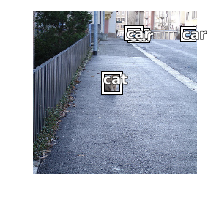

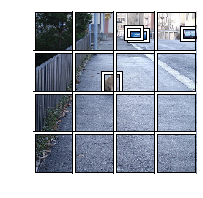

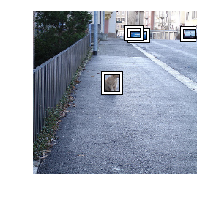

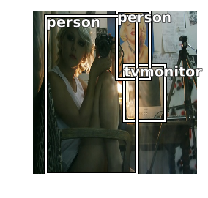

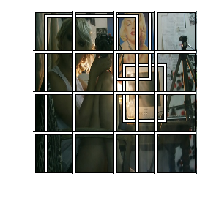

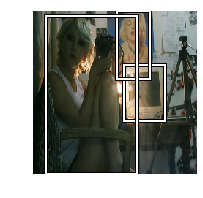

In [356]:
qt_display_img_with_bbox()